In [430]:
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy
from abc import ABC, abstractmethod

## Initialize a Tic-Tac-Toe Game

In [436]:
# step1: set up the environment
class TicTacToe:
    def __init__(self):
        self.board = [' ' for _ in range(9)]
        self.current_winner = None

    def print_board(self):
        # Print the board
        for row in [self.board[i*3:(i+1)*3] for i in range(3)]:
            print('| ' + ' | '.join(row) + ' |')

    def available_moves(self):
        # print out the index of the available moves from 0 to 8
        return [i for i, x in enumerate(self.board) if x == ' ']

    def make_move(self, square, letter):
        if self.board[square] == ' ':
            self.board[square] = letter # make the move
            if self.winner(square, letter): # check if the move is a winning move
                self.current_winner = letter # update the winner   
            return True # return True if the move is valid
        return False # return False if the move is invalid

    def winner(self, square, letter):
        # Check the row
        row_ind = square // 3 # first row is 0, second row is 1, third row is 2
        row = self.board[row_ind*3:(row_ind+1)*3] # get the row, e.g. [0, 1, 2], [3, 4, 5], [6, 7, 8]
        if all([s == letter for s in row]):
            return True

        # Check the column
        col_ind = square % 3 # first column is 0, second column is 1, third column is 2
        column = [self.board[col_ind+i*3] for i in range(3)] # get the column, e.g. [0, 3, 6], [1, 4, 7], [2, 5, 8]
        if all([s == letter for s in column]):
            return True

        # Check diagonals
        if square % 2 == 0: # check 0 4 8 or 2 4 6
            diagonal1 = [self.board[i] for i in [0, 4, 8]]
            if all([s == letter for s in diagonal1]):
                return True
            diagonal2 = [self.board[i] for i in [2, 4, 6]]
            if all([s == letter for s in diagonal2]):
                return True
        return False

    def gameover(self):
    # Check if either 'X' or 'O' has won
        return any(self.winner(square, letter) for square in range(9) for letter in ['X', 'O']) or self.tie()

    def tie(self):
        # all the spaces are filled
        return all([s != ' ' for s in self.board])

    def reset(self):
        self.board = [' ' for _ in range(9)]
        self.current_winner = None

class Player(ABC):
    def __init__(self, letter):
        self.letter = letter

    @abstractmethod
    def choose_action(self, game):
        pass
    @abstractmethod
    def __str__(self) -> str:
        pass
    @abstractmethod
    def __repr__(self) -> str:
        pass


### Demonstration of game

In [244]:
## demonstration of a game
game = TicTacToe()
game.print_board()

|   |   |   |
|   |   |   |
|   |   |   |


In [245]:
game.make_move(0, 'X')
game.print_board()
game.gameover()

| X |   |   |
|   |   |   |
|   |   |   |


False

In [246]:
game.make_move(1, 'O')
game.make_move(2, 'X')
game.make_move(3, 'O')
game.make_move(4, 'X')
game.make_move(5, 'O')
game.make_move(6, 'X')
game.print_board()
print(f"Available moves are: {game.available_moves()}")
game.make_move(7, 'O')
game.make_move(8, 'X')
game.print_board()
game.gameover()
game.reset()
print("reset game")
game.print_board()

| X | O | X |
| O | X | O |
| X |   |   |
Available moves are: [7, 8]
| X | O | X |
| O | X | O |
| X | O | X |
reset game
|   |   |   |
|   |   |   |
|   |   |   |


## Build a Q-learning Agent

In [556]:
class RLAgent:
    def __init__(self, letter, alpha=0.2, gamma=1):
        self.alpha = alpha
        self.gamma = gamma
        self.Q = {}  # state-action pair to value
        self.epsilon = 0.2  # exploration rate/ epsilon
        self.epsilon_min = 0.1
        # use a smooth decay for epsilon
        self.epsilon_decay = 0.999
        self.letter = letter
        self.default_reward = 0

    def get_state(self, game):
        return str(game.board)

    def update_Q(self, state, next_state, action, reward):
        max_future_q = max(self.Q.get(next_state, {}).values(), default=self.default_reward)
        # initialzie the Q-value to 1 if the state is not in the Q-table
        current_q = self.Q.get(state, {}).get(action, self.default_reward) # get the current Q-value, 0.5 means the default value
        new_q = (1 - self.alpha) * current_q + self.alpha * (reward + self.gamma * max_future_q)
        self.Q.setdefault(state, {})[action] = new_q # update Q-value

    def choose_action(self,game):
        if np.random.uniform(0, 1) < self.epsilon:
            action = random.choice(game.available_moves())
        else:
            state = self.get_state(game)
            q_values = self.Q.get(state, {})
            action = max(game.available_moves(), key=lambda x: q_values.get(x, self.default_reward))
        return action

    def decrease_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def __str__(self) -> str:
        return f"RLAgent {self.letter}"
    
    def __repr__(self) -> str:
        return f"RLAgent {self.letter}"

# train Q-agent against a non-Q player
def play_game(agent, game, player):
    """this is only for the training loop of Q-learning agent against non-Q player
    default reward is 0 for non-terminal states
    1 for winning, 0 for losing, 0.5 for draw"""  
    # Randomly choose the starting player
    current_player = np.random.choice([agent, player])
    # input the letter for agent and player for later use
    agent_letter = agent.letter
    player_letter = player.letter

    while True:
        state = agent.get_state(game)
        available_actions = game.available_moves()

        if current_player == agent:
            action = agent.choose_action(game)
            game.make_move(action, agent_letter)
            # Update Q-value for the previous non-terminal state
            new_state = agent.get_state(game)
            agent.update_Q(state, new_state, action, agent.default_reward)
        else:
            action = player.choose_action(game)  # Assuming player has a choose_action method
            game.make_move(action, player_letter)

        # Determine reward
        if game.current_winner or len(game.available_moves()) == 0:
            if game.current_winner == agent_letter:  # Agent wins
                reward = 1
            elif game.current_winner == player_letter:  # Agent loses
                reward = -1
            else:  # It's a draw
                reward = 0.5

            # Update Q-value for the terminal state
            if current_player == agent:
                agent.update_Q(state, new_state, action, reward)
            break  # End the game loop

        # Prepare for the next iteration
        current_player = player if current_player == agent else agent
    return reward

## Build TD Agent

In [520]:
class TDAgent(Player):
    """Temporal Difference Learning Agent
    update rule is given by V(s) = (1 - alpha) * V(s) + alpha * V(s')
    where V(s') is the value of the next state"""
    def __init__(self, letter, alpha=0.4):
        super().__init__(letter)
        self.alpha = alpha
        self.V = {}  # state to value
        self.epsilon = 0.2  # exploration rate/ epsilon
        self.epsilon_min = 0.1
        # use a smooth decay for epsilon
        self.epsilon_decay = 0.999

    def get_state(self, game):
        return str(game.board) # get the state which is the board

    def update_V_reward(self, state, next_state):
        """update the value of the state as  V(s) = (1 - alpha) * V(s) + alpha * V(s')
        each value represent the probability of winning"""
        next_state_value = self.V.get(next_state, 0.5)
        current_value = self.V.get(state, 0.5)
        new_value =  current_value + self.alpha * (next_state_value - current_value)
        self.V[state] = new_value

    def set_state_value(self, state, value):
        self.V[state] = value

    def choose_action(self, game):
        """search for the next states without changing the game, then choose the action with the highest value"""
        available_actions = game.available_moves()
        next_states = []
        # epsilon
        if np.random.uniform(0, 1) < self.epsilon:
            return random.choice(available_actions)
        # greedy
        for action in available_actions:
            game_copy = copy.deepcopy(game) # make a copy of the game to avoid changing the original game
            game_copy.make_move(action, self.letter) # make the move
            next_states.append(self.get_state(game_copy)) # get the next state
        next_state_values = [self.V.get(state, 0.5) for state in next_states]
        action = available_actions[np.argmax(next_state_values)]
        return action

    def decrease_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def __str__(self) -> str:
        return f"TDAgent {self.letter}"
    
    def __repr__(self) -> str:
        return f"TDAgent {self.letter}"

# train TD-agent against a non-TD player
def play_game_TD(agent, game, player):
    """this is only for the training loop of TD-learning agent against non-TD player
    default reward is 0 for non-terminal states
    1 for winning, 0 for losing or draw
    and the value at each state is the probability of winning"""  
    # Randomly choose the starting player
    current_player = np.random.choice([agent, player])

    # input the letter for agent and player for later use
    agent_letter = agent.letter
    player_letter = player.letter

    while True:
        state = agent.get_state(game) # the state V(s)
        available_actions = game.available_moves()

        if current_player == agent:
            action = agent.choose_action(game)
            game.make_move(action, agent_letter)
        else:
            action = player.choose_action(game)  # Assuming player has a choose_action method
            game.make_move(action, player_letter) # make the move
        next_state = agent.get_state(game) # get the next state

        # if the game finish, update the value for this state corresponding to the result
        if game.current_winner or len(game.available_moves()) == 0:
            if game.current_winner == agent_letter:
                agent.set_state_value(next_state, 1) # Agent wins, so set the value for V(s') to 1
            else: # Agent loss or tie
                agent.set_state_value(next_state, 0)
            # update the value for the current state
            agent.update_V_reward(state, next_state)
            break
        # update the value for the current state
        agent.update_V_reward(state, next_state)
        # Prepare for the next iteration
        current_player = player if current_player == agent else agent

    

## Initialize Opponent and Human

In [444]:
class RandomPlayer(Player):
    def __init__(self, letter):
        self.letter = letter
    
    def choose_action(self, game):
        return np.random.choice(game.available_moves())
    
    def __str__(self) -> str:
        """it is a RandomPlayer"""
        return f"RandomPlayer with {self.letter}"
    
    def __repr__(self) -> str:
        """it is a RandomPlayer"""
        return f"RandomPlayer with {self.letter}"

class WinningMovePlayer(Player):
    """The 2nd type of player who will choose the winning move if available, otherwise choose randomly"""
    def __init__(self, letter):
        self.letter = letter

    def choose_action(self, game):
        # First, check if a winning move is available
        for move in game.available_moves():
            game_copy = copy.deepcopy(game) # make a copy of the game to avoid changing the original game
            game_copy.make_move(move, self.letter) # make the move
            if game_copy.winner(move, self.letter):
                return move
        # if no winning move, then randomly choose a move
        return np.random.choice(game.available_moves())
    
    def __str__(self) -> str:
        """it is a WinningMovePlayer"""
        return f"WinningMovePlayer with {self.letter}"
    
    def __repr__(self) -> str:
        """it is a WinningMovePlayer"""
        return f"WinningMovePlayer with {self.letter}"

class ThandPlayer(Player):
    def __init__(self, letter):
        self.letter = letter

    def choose_action(self, game):
        # First, check if a winning move is available
        for move in game.available_moves():
            game_copy = copy.deepcopy(game) # make a copy of the game to avoid changing the original game
            game_copy.make_move(move, self.letter) # make the move
            if game_copy.winner(move, self.letter):
                return move

        # then check if the opponent has a winning move
        for move in game.available_moves():
            game_copy = copy.deepcopy(game)
            opponent_letter = 'X' if self.letter == 'O' else 'O'
            game_copy.make_move(move, opponent_letter) #
            if game.winner(move, opponent_letter): # check if the opponent has a winning move
                return move

        # If no winning move, pick randomly
        return np.random.choice(game.available_moves())
    
    def __str__(self) -> str:
        """it is a ThandPlayer"""
        return f"ThandPlayer with {self.letter}"
    
    def __repr__(self) -> str:
        """it is a ThandPlayer"""
        return f"ThandPlayer with {self.letter}"

class HumanPlayer(Player):
    def __init__(self, letter):
        self.letter = letter

    def choose_action(self, game):
        while True:
            move = input("Choose move (0-8): ")
            if move.isdigit() and int(move) in game.available_moves():
                return int(move)
            else:
                print("Invalid move. Try again.")
                move = input("Choose move (0-8): ")

    def __str__(self) -> str:
        """it is a HumanPlayer"""
        return f"HumanPlayer with {self.letter}"

    def __repr__(self) -> str:
        """it is a HumanPlayer"""
        return f"HumanPlayer with {self.letter}"


## Evaluation Tool

In [300]:
# Plot results
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [543]:
def evaluate(agent1, agent2, game, num_games=100,verbose = False, default_epsilon = 0):
    """
    evalute the agent1 performance against the agent2, need to set epislon to 0 to make sure the agent always chooses the best move.
    randomly select agent for opponent for the first move each game
    return the win probability for agent1, the tie probability and the lose probability
    """
    agent1_wins = 0
    agent2_wins = 0
    draws = 0
    epsilon1 = None
    epsilon2 = None
    # if the agent is Q-player or TD-player, set epsilon to 0 to make sure the agent always chooses the best move
    # Save and set epsilon for agent if it's a Q-learning agent/ TD agent
    if isinstance(agent1, RLAgent) or isinstance(agent1, TDAgent):
        epsilon1 = agent1.epsilon  # save the current epsilon
        agent1.epsilon = default_epsilon  # set epsilon to default 0 for evaluation
    if isinstance(agent2, RLAgent) or isinstance(agent2, TDAgent):
        epsilon2 = agent2.epsilon
        agent2.epsilon = default_epsilon
    # start evalutation
    for _ in range(num_games):
        game.reset()
        current_player = np.random.choice([agent1, agent2]) # randomly choose the starting player
        while True:
            
            if current_player == agent1:
                action = agent1.choose_action(game)
                game.make_move(action, agent1.letter)
            else:
                action = agent2.choose_action(game)
                game.make_move(action, agent2.letter)

            # if there is a winner
            if game.current_winner: 
                if game.current_winner == agent1.letter:
                    agent1_wins += 1
                else:
                    agent2_wins += 1
                break
            if game.tie():
                draws += 1
                break
            # switch player
            current_player = agent2 if current_player == agent1 else agent1
    # reset epsilon for agent1 and agent2
    if isinstance(agent1, RLAgent) or isinstance(agent1, TDAgent):
        agent1.epsilon = epsilon1
    if isinstance(agent2, RLAgent) or isinstance(agent2, TDAgent):
        agent2.epsilon = epsilon2
    if verbose:
        print(f"{agent1} wins: {agent1_wins} / {num_games}, Draws: {draws} / {num_games}, {agent2} wins: {agent2_wins} / {num_games}")
    win_prob = agent1_wins / num_games # win probability for agent1
    tie_prob = draws / num_games
    lose_prob = agent2_wins / num_games
    return win_prob, tie_prob, lose_prob

## Train and Evaluate TD-player

  2%|▏         | 971/50000 [00:00<00:18, 2696.73it/s]

Episode 0
epsilon: 0.1998
size of state  pair: 6
win probability: 0.627


 41%|████      | 20542/50000 [00:08<00:09, 2976.44it/s]

Episode 20000
epsilon: 0.1
size of state  pair: 4906
win probability: 0.911


 81%|████████  | 40554/50000 [00:15<00:03, 2994.98it/s]

Episode 40000
epsilon: 0.1
size of state  pair: 5989
win probability: 0.909


100%|██████████| 50000/50000 [00:19<00:00, 2599.43it/s]


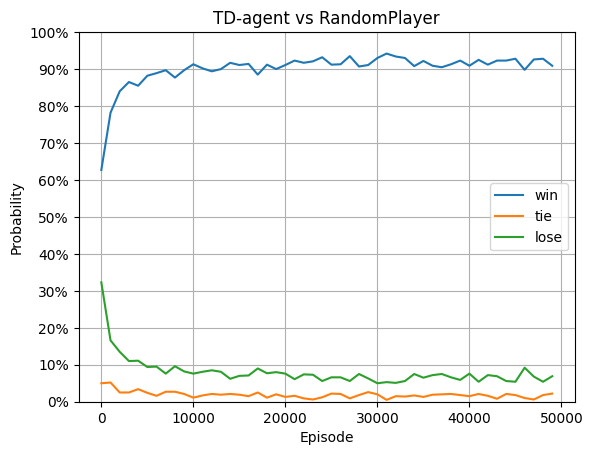

In [522]:
# train a TD-agent against random
TD_agent1 = TDAgent('X')
player1 = RandomPlayer('O')
player2 = WinningMovePlayer('O')
player3 = ThandPlayer('O')
number_of_episodes = 50000
win_list = []
tie_list = []
lose_list = []
freq = 1000 # evaluate the agent every 1000 episodes
for _ in tqdm(range(number_of_episodes)):  # Increase the number of training games as needed
    game.reset()
    result = play_game_TD(TD_agent1, game, player1)
    TD_agent1.decrease_epsilon()
    if _ % freq == 0:
 
        win_prob,tie_prob,lose_prob = evaluate(TD_agent1, player1,game,freq)
        win_list.append(win_prob)
        tie_list.append(tie_prob)
        lose_list.append(lose_prob)
       
    if _ % (20*freq) == 0:
        print(f"Episode {_}")
        print(f"epsilon: {TD_agent1.epsilon}")
        print(f"size of state pair: {len(TD_agent1.V)}")
        print(f"win probability: {win_prob}")

xs = freq*np.arange(len(win_list))
plt.plot(xs,win_list, label = 'win')
plt.xlabel('Episode')
plt.plot(xs,tie_list,label = "tie") 
plt.plot(xs,lose_list, label = "lose")
plt.xlabel('Episode')
plt.ylabel('Probability')
plt.ylim(0,1)
plt.yticks(np.arange(0,1.1,0.1))
plt.title('TD-agent vs RandomPlayer')
plt.grid()
plt.legend()
# convert y to percentage
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
# lose prob
plt.show()

  1%|          | 599/100000 [00:00<01:07, 1475.05it/s]

Episode 0
epsilon: 0.1998
size of state  pair: 6
win probability: 0.457


 21%|██        | 20826/100000 [00:14<00:44, 1793.58it/s]

Episode 20000
epsilon: 0.1
size of state  pair: 6100
win probability: 0.893


 41%|████      | 40538/100000 [00:27<00:39, 1521.33it/s]

Episode 40000
epsilon: 0.1
size of state  pair: 7099
win probability: 0.889


 60%|██████    | 60326/100000 [00:40<00:27, 1451.52it/s]

Episode 60000
epsilon: 0.1
size of state  pair: 7401
win probability: 0.906


 80%|████████  | 80485/100000 [00:54<00:12, 1532.26it/s]

Episode 80000
epsilon: 0.1
size of state  pair: 7578
win probability: 0.896


100%|██████████| 100000/100000 [01:07<00:00, 1473.46it/s]


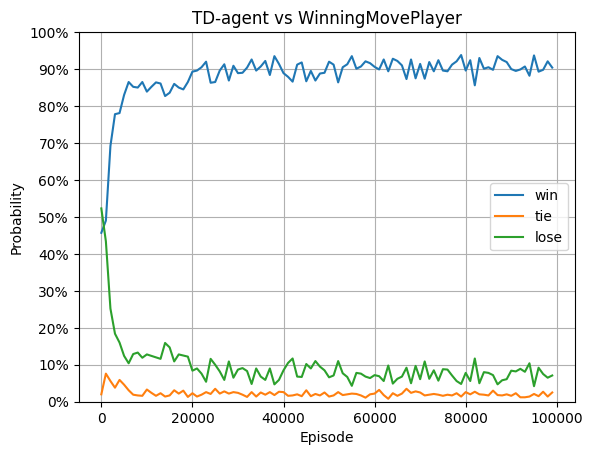

In [523]:
# train a TD-agent against WinningMovePlayer
TD_agent2 = TDAgent('O')
player1 = RandomPlayer('X')
player2 = WinningMovePlayer('X')
player3 = ThandPlayer('X')
number_of_episodes = 100000
win_list = []
tie_list = []
lose_list = []
freq = 1000
for _ in tqdm(range(number_of_episodes)):  # Increase the number of training games as needed
    game.reset()
    result = play_game_TD(TD_agent2, game, player2)
    TD_agent2.decrease_epsilon()
    if _ % freq == 0:
 
        win_prob,tie_prob,lose_prob = evaluate(TD_agent2, player2,game,freq)
        win_list.append(win_prob)
        tie_list.append(tie_prob)
        lose_list.append(lose_prob)
       
    if _ % (20*freq) == 0:
        print(f"Episode {_}")
        print(f"epsilon: {TD_agent2.epsilon}")
        print(f"size of state pair: {len(TD_agent2.V)}")
        print(f"win probability: {win_prob}")

xs = freq*np.arange(len(win_list))
plt.plot(xs,win_list, label = 'win')
plt.xlabel('Episode')
plt.plot(xs,tie_list,label = "tie") 
plt.plot(xs,lose_list, label = "lose")
plt.xlabel('Episode')
plt.ylabel('Probability')
plt.grid()
plt.ylim(0,1)
plt.yticks(np.arange(0,1.1,0.1))
plt.title('TD-agent vs WinningMovePlayer')
plt.legend()
# convert y to percentage
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
# lose prob
plt.show()

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 228/50000 [00:00<01:40, 492.86it/s]

Episode 0
epsilon: 0.1998
size of state pair: 6
win probability: 0.46


 41%|████      | 20297/50000 [00:19<00:34, 854.09it/s] 

Episode 20000
epsilon: 0.1
size of state pair: 6370
win probability: 0.898


 81%|████████  | 40276/50000 [00:38<00:09, 1000.02it/s]

Episode 40000
epsilon: 0.1
size of state pair: 7197
win probability: 0.881


100%|██████████| 50000/50000 [00:46<00:00, 1064.85it/s]


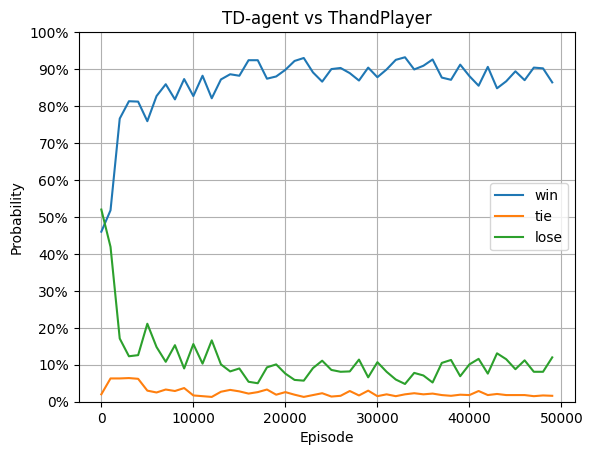

In [524]:
# train a TD-agent against ThandPlayer
TD_agent3 = TDAgent('O')
player1 = RandomPlayer('X')
player2 = WinningMovePlayer('X')
player3 = ThandPlayer('X')
number_of_episodes = 50000
win_list = []
tie_list = []
lose_list = []
freq = 1000
for _ in tqdm(range(number_of_episodes)):  # Increase the number of training games as needed
    game.reset()
    result = play_game_TD(TD_agent3, game, player3)
    TD_agent3.decrease_epsilon()
    if _ % freq == 0:
 
        win_prob,tie_prob,lose_prob = evaluate(TD_agent3, player3,game,freq)
        win_list.append(win_prob)
        tie_list.append(tie_prob)
        lose_list.append(lose_prob)
       
    if _ % (20*freq) == 0:
        print(f"Episode {_}")
        print(f"epsilon: {TD_agent3.epsilon}")
        print(f"size of state pair: {len(TD_agent3.V)}")
        print(f"win probability: {win_prob}")

xs = freq*np.arange(len(win_list))
plt.plot(xs,win_list, label = 'win')
plt.xlabel('Episode')
plt.plot(xs,tie_list,label = "tie") 
plt.plot(xs,lose_list, label = "lose")
plt.xlabel('Episode')
plt.ylabel('Probability')
plt.grid()
plt.ylim(0,1)
plt.yticks(np.arange(0,1.1,0.1))
plt.title('TD-agent vs ThandPlayer')
plt.legend()
# convert y to percentage
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
# lose prob
plt.show()

In [546]:
# Evaluate TDplayer against each other
TD_agent1.letter = 'X'
TD_agent2.letter = 'O'
TD_agent3.letter = 'X'
evaluate(TD_agent1, TD_agent2, game, num_games=1000,verbose = True,default_epsilon = 0)


TDAgent X wins: 511 / 1000, Draws: 0 / 1000, TDAgent O wins: 489 / 1000


(0.511, 0.0, 0.489)

In [547]:
# explicitly demonstrate a game
TD_agent2.epsilon = 0
TD_agent3.epsilon = 0
def demonstrate_game(agent1, agent2, game):
    current_player = np.random.choice([agent1, agent2])
    while True:
        if current_player == agent1:
            action = agent1.choose_action(game)
            game.make_move(action,agent1.letter)
            
        else:
            action = agent2.choose_action(game)
            game.make_move(action,agent2.letter)
        game.print_board()
        print("-------------")
        if game.gameover():
            if game.current_winner:
                print(f"{agent1 if agent1.letter == game.current_winner else agent2} wins")
            else:
                print("It's a tie")
            break
        current_player = agent2 if current_player == agent1 else agent1

game = TicTacToe()
demonstrate_game(TD_agent2, TD_agent3, game)

|   |   |   |
| X |   |   |
|   |   |   |
-------------
|   |   |   |
| X | O |   |
|   |   |   |
-------------
|   | X |   |
| X | O |   |
|   |   |   |
-------------
|   | X |   |
| X | O |   |
| O |   |   |
-------------
|   | X |   |
| X | O |   |
| O | X |   |
-------------
|   | X | O |
| X | O |   |
| O | X |   |
-------------
TDAgent O wins


## Train and Evaluate Q-player

  1%|▏         | 2544/200000 [00:00<00:22, 8804.30it/s]

Episode 0
epsilon: 0.1998
size of state action pair: 4


 11%|█         | 21001/200000 [00:02<00:19, 9270.61it/s]

Episode 20000
epsilon: 0.1
size of state action pair: 2859


 21%|██        | 41001/200000 [00:04<00:16, 9505.91it/s]

Episode 40000
epsilon: 0.1
size of state action pair: 3622


 31%|███       | 61001/200000 [00:06<00:14, 9337.43it/s]

Episode 60000
epsilon: 0.1
size of state action pair: 4190


 41%|████      | 81001/200000 [00:08<00:12, 9430.78it/s]

Episode 80000
epsilon: 0.1
size of state action pair: 4656


 51%|█████     | 101001/200000 [00:10<00:10, 9260.93it/s]

Episode 100000
epsilon: 0.1
size of state action pair: 5011


 61%|██████    | 122001/200000 [00:13<00:08, 8742.46it/s]

Episode 120000
epsilon: 0.1
size of state action pair: 5350


 71%|███████   | 141001/200000 [00:15<00:06, 9318.18it/s]

Episode 140000
epsilon: 0.1
size of state action pair: 5663


 81%|████████  | 161001/200000 [00:17<00:04, 9170.38it/s]

Episode 160000
epsilon: 0.1
size of state action pair: 5899


 91%|█████████ | 181001/200000 [00:19<00:02, 9409.63it/s]

Episode 180000
epsilon: 0.1
size of state action pair: 6105


100%|██████████| 200000/200000 [00:21<00:00, 9221.07it/s]
/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_62710/455554169.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


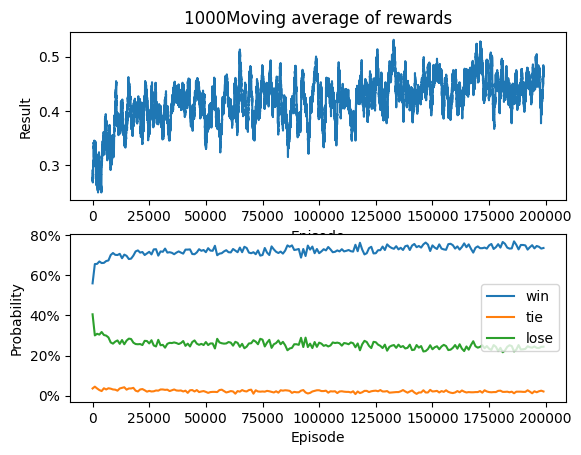

In [557]:
# train a Q-agent against a non-Q player
results = []
agent1 = RLAgent('X')
player1 = RandomPlayer('O')
player2 = WinningMovePlayer('O')
player3 = ThandPlayer('O')
number_of_episodes = 100000
win_list = []
tie_list = []
lose_list = []
freq = 1000
for _ in tqdm(range(number_of_episodes)):  # Increase the number of training games as needed
    game.reset()
    result = play_game(agent1, game, player1)
    agent1.decrease_epsilon()
    results.append(result) # append the total reward after each episode
    if _ % freq == 0:
 
        win_prob,tie_prob,lose_prob = evaluate(agent1, player1,game,freq)
        win_list.append(win_prob)
        tie_list.append(tie_prob)
        lose_list.append(lose_prob)
       
    if _ % (20*freq) == 0:
        print(f"Episode {_}")
        print(f"epsilon: {agent1.epsilon}")
        print(f"size of state action pair: {sum(len(values) for values in agent1.Q.values())}")


results = moving_average(results, freq)
plt.subplot(2, 1, 1)
plt.plot(results)
plt.xlabel('Episode')
plt.ylabel('Result')
plt.title(f'{freq}Moving average of rewards')
plt.subplot(2, 1, 2) # plot win prob
xs = freq*np.arange(len(win_list))
plt.plot(xs,win_list, label = 'win')
plt.xlabel('Episode')
plt.plot(xs,tie_list,label = "tie") 
plt.plot(xs,lose_list, label = "lose")
plt.xlabel('Episode')
plt.ylabel('Probability')
plt.legend()
# convert y to percentage
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
# lose prob
plt.show()

  0%|          | 312/100000 [00:00<01:38, 1007.76it/s]

Episode 0
epsilon: 0.1998
length of Q:3
size of state action pair: 3


 21%|██        | 20806/100000 [00:12<00:40, 1942.26it/s]

Episode 20000
epsilon: 0.1
length of Q:1468
size of state action pair: 2463


 40%|████      | 40499/100000 [00:24<00:35, 1666.07it/s]

Episode 40000
epsilon: 0.1
length of Q:1751
size of state action pair: 3149


 61%|██████    | 60764/100000 [00:36<00:20, 1914.67it/s]

Episode 60000
epsilon: 0.1
length of Q:1945
size of state action pair: 3656


 80%|████████  | 80481/100000 [00:48<00:11, 1665.62it/s]

Episode 80000
epsilon: 0.1
length of Q:2084
size of state action pair: 4058


100%|██████████| 100000/100000 [01:00<00:00, 1647.81it/s]
/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_62710/2514652493.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


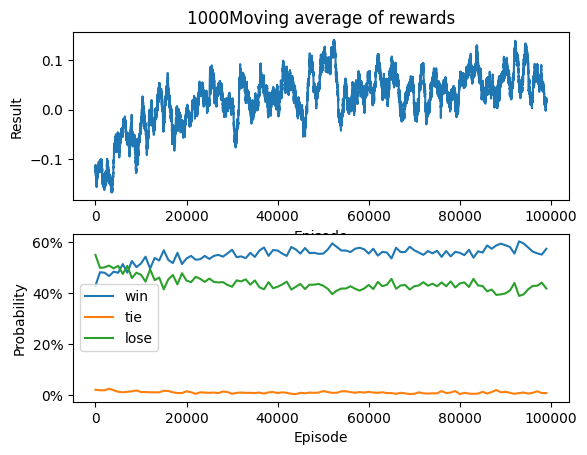

In [558]:
# Train another Q-learning agent called agent2
results = []
agent2 = RLAgent('O')
player3 = ThandPlayer('X')
number_of_episodes = 100000
win_list = []
tie_list = []
lose_list = []
freq = 1000
for _ in tqdm(range(number_of_episodes)):  # Increase the number of training games as needed
    game.reset()
    result = play_game(agent2, game, player3)
    agent2.decrease_epsilon()
    results.append(result) # append the total reward after each episode
    if _ % freq == 0:
        win_prob,tie_prob,lose_prob = evaluate(agent2, player3,game,freq)
        win_list.append(win_prob)
        tie_list.append(tie_prob)
        lose_list.append(lose_prob)
    if _ % (20*freq) == 0:
        print(f"Episode {_}")
        print(f"epsilon: {agent2.epsilon}")
        print(f"length of Q:{len(agent2.Q)}")
        print(f"size of state action pair: {sum(len(values) for values in agent2.Q.values())}")


results = moving_average(results, freq)
plt.subplot(2, 1, 1)
plt.plot(results)
plt.xlabel('Episode')
plt.ylabel('Result')
plt.title(f'{freq}Moving average of rewards')
plt.subplot(2, 1, 2) # plot win prob
xs = freq*np.arange(len(win_list))
plt.plot(xs,win_list, label = 'win')
plt.xlabel('Episode')
plt.plot(xs,tie_list,label = "tie") 
plt.plot(xs,lose_list, label = "lose")
plt.xlabel('Episode')
plt.ylabel('Probability')
plt.legend()
# convert y to percentage
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
# lose prob
plt.show()

In [566]:
# let ThandPlayer play against Random Player
game.reset()
player1 = RandomPlayer('O')
player2 = ThandPlayer('O')
player3 = WinningMovePlayer('X')
w,t,l = evaluate(player2, player3, game, 1000,verbose = True)


ThandPlayer with O wins: 479 / 1000, Draws: 58 / 1000, WinningMovePlayer with X wins: 463 / 1000


## Play with human

In [364]:
def play_with_human(agent, game, human):
    current_player = np.random.choice([agent, human])
    agent_char = agent.letter
    human_char = human.letter
    #game.print_board()
    while True:
        state = agent.get_state(game)
        if current_player == agent:
            action = agent.choose_action(game)
            game.make_move(action, agent_char)
            game.print_board()
        else:
            action = human.choose_action(game)
            game.make_move(action, human_char)
            #game.print_board()
        if game.current_winner:
            if game.current_winner == agent_char:
                print("Agent wins!")
            else:
                print("You  wins!")
            break
        if len(game.available_moves()) == 0:
            print("It's a draw!")
            break
        current_player = human if current_player == agent else agent # switch player

In [551]:
# play with human9
# Choose an agent with charactor 'X' to play with human
TD_agent1.letter = 'X'
game = TicTacToe()
play_with_human(TD_agent1, game, HumanPlayer('O'))

| X |   |   |
|   |   |   |
|   |   |   |
| X |   |   |
| X | O |   |
|   |   |   |
| X | X |   |
| X | O |   |
| O |   |   |
You  wins!
